In [1]:
from transmission_line_simulator import *
from coplanar_coupler import *
import coplanar_coupler
import scipy.constants
import sympy
import scipy.optimize
import imp
imp.reload(coplanar_coupler)

<module 'coplanar_coupler' from 'C:\\Documents-cloud\\qubits\\simulation\\coupling_paper\\cpw_coupling\\coplanar_coupler.py'>

# transmission line circuit topology

In [2]:
claw = capacitor()
qubit_cap = capacitor()
qubit_inductor = inductor()
#L = inductor()
source = port()
#source_feedline = transmission_line()
analyzer_feedline = transmission_line_coupler(n=1)
analyzer = port()

GND = short()
resonator_short_end = transmission_line_coupler(n=1)
resonator_claw_end = transmission_line_coupler(n=1)#
coupler = transmission_line_coupler()
res = resistor()

circuit = transmission_line_system()
circuit.add_element(coupler, [1, 2, 3, 4])
circuit.add_element(source, [1])
circuit.add_element(analyzer_feedline, [3, 8])
circuit.add_element(analyzer, [8])
circuit.add_element(resonator_short_end, [4, 0])
#circuit.add_element(res, [7, 0])
circuit.add_element(resonator_claw_end, [2, 6])
#circuit.add_element(claw, [6, 7])
#circuit.add_element(qubit_cap, [7, 0])
#circuit.add_element(qubit_inductor, [7, 0])
circuit.add_element(GND, [0])

# symbolic system parameters

In [3]:
c_l =sympy.Symbol('c_l', real=True, positive=True)
Zi = sympy.Symbol('Z_i', real=True, positive=True)
Zo = sympy.Symbol('Z_o', real=True, positive=True)
Zf = sympy.Symbol('Z_f', real=True, positive=True)
Za = sympy.Symbol('Z_a', real=True, positive=True)
Zr = sympy.Symbol('Z_r', real=True, positive=True)
l_f = sympy.Symbol('l_f', real=True, positive=True) # feedline residual length
C_c =sympy.Symbol('C_c', real=True, positive=True)
l_s = sympy.Symbol('l_s', real=True, positive=True)
l_o = sympy.Symbol('l_o', real=True, positive=True)
l_c = sympy.Symbol('l_c', real=True, positive=True)
Z1 = sympy.Symbol('Z1', real=True, positive=True)
Z2 = sympy.Symbol('Z2', real=True, positive=True)
kappa = sympy.Symbol('\\kappa', real=True, positive=True)
#gamma = sympy.sqrt(sympy.nsimplify(1)-kappa*kappa)
gamma = sympy.Symbol('\\gamma', real=True, positive=True)
R = sympy.Symbol('R', real=True, positive=True)
omega = sympy.Symbol('\\omega')
domega = sympy.Symbol('\\Delta\\omega')

Lq = sympy.Symbol('L_q', positive=True)
Cq = sympy.Symbol('C_q', positive=True)

qubit_cap.C = Cq
qubit_inductor.L = Lq

coupler.l = l_c
coupler.Ll = sympy.Matrix([[(Z1*gamma)/c_l, kappa*gamma*sympy.sqrt(Z1)*sympy.sqrt(Z2)/c_l], \
                           [kappa*gamma*sympy.sqrt(Z1)*sympy.sqrt(Z2)/c_l, (Z2*gamma)/c_l]])
coupler.Cl = coupler.Ll.inv()/(c_l**2)
coupler.Rl = np.zeros(coupler.Ll.shape, dtype=np.int)
coupler.Gl = np.zeros(coupler.Ll.shape, dtype=np.int)

source.Z0 = Zi
analyzer.Z0 = Zo

res.R = R

analyzer_feedline.l = l_f
analyzer_feedline.Cl = sympy.Matrix([[1/(c_l*Za)]])
analyzer_feedline.Ll = sympy.Matrix([[Za/c_l]])
analyzer_feedline.Rl = sympy.Matrix([[0]])
analyzer_feedline.Gl = sympy.Matrix([[0]])

resonator_short_end.l = l_s
resonator_short_end.Cl = sympy.Matrix([[1/(c_l*Zr)]])
resonator_short_end.Ll = sympy.Matrix([[Zr/c_l]])
resonator_short_end.Rl = sympy.Matrix([[0]])
resonator_short_end.Gl = sympy.Matrix([[0]])
resonator_claw_end.l = l_o
resonator_claw_end.Cl = sympy.Matrix([[1/(c_l*Zr)]])
resonator_claw_end.Ll = sympy.Matrix([[Zr/c_l]])
resonator_claw_end.Rl = sympy.Matrix([[0]])
resonator_claw_end.Gl = sympy.Matrix([[0]])
claw.C = C_c

# creating boundary problem matrix

In [4]:
boundary_problem = circuit.create_boundary_problem_matrix(sympy.Symbol('\\omega'))
for i in range(boundary_problem.shape[0]):
    for j in range(boundary_problem.shape[1]):
        boundary_problem[i,j] = sympy.nsimplify(boundary_problem[i,j]).xreplace({gamma:sympy.sqrt(sympy.nsimplify(1)-kappa*kappa)})
boundary_problem

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

# Expanding determinant to first order (this can take > 1 hour)

In [5]:
# M1 = sympy.Matrix(boundary_problem)
#for i in range(boundary_problem.shape[0]):
#    for j in range(boundary_problem.shape[1]):
#        M1[i,j] = M1[i,j].subs({M:0, Z1:Z0, Z2:Zr})
#
#circuit.matrix_reduce(M1)
subs = {kappa:sympy.nsimplify(0), Z1:Zf, Z2:Zr, C_c:sympy.nsimplify(0), R:sympy.nsimplify(0)}
Ml = [sympy.Matrix(boundary_problem)] 
print ('Ml len', len(Ml))
Odl = matrix_list_determinant_derivative(Ml, sympy.Symbol('\\omega'))
print ('Odl len', len(Odl))
Mdl = matrix_list_determinant_derivative(Ml, kappa)
print ('Mdl len', len(Mdl))
Mddl = matrix_list_determinant_derivative(Mdl, kappa)
print ('Mddl len', len(Mddl))
Z1dl = matrix_list_determinant_derivative(Ml, Z1)
print ('Z1dl len', len(Z1dl))
Z2dl = matrix_list_determinant_derivative(Ml, Z2)
print ('Z2dl len', len(Z2dl))
Cdl = matrix_list_determinant_derivative(Ml, C_c)
print ('Cdl len', len(Cdl))
MdCdl = matrix_list_determinant_derivative(Cdl, kappa)
print ('MdCdl len', len(MdCdl))
MddCdl = matrix_list_determinant_derivative(MdCdl, kappa)
print ('MddCdl len', len(MddCdl))
Rdl = matrix_list_determinant_derivative(Ml, R)
print ('Rdl len', len(Rdl))

matrix_lists = [Ml, Odl, Mdl, Mddl, Z1dl, Z2dl, Cdl, MdCdl, MddCdl, Rdl]
#matrix_lists = [Ml, Mdl, Z1dl, Z2dl]
factors = [sympy.ones(1)[0], domega, kappa, kappa**2/sympy.nsimplify(2), 
           Z1-Zf, Z2-Zr, C_c, C_c*kappa/2, C_c*kappa**2/4, R]
derivatives = []
#matrix_lists = [Ml, Mdl, Z1dl, Z2dl, Cdl]
#factors = [sympy.ones(1)[0], M, Z1-Z0, Z2-Z0, C_c]

print('matrix lists len', sum(len(m) for m in matrix_lists))
import time
begin=time.time()
matrix_lists_point = [matrix_list_subs(Ms, subs) for Ms in matrix_lists]
print('xreplace time: ', time.time()-begin)
determinants = []
for Ms in matrix_lists_point:
    begin = time.time()
    determinants.append(sympy.simplify(sympy.ratsimp(matrix_list_determinant(Ms))))
    print('list size ', len(Ms), ' deteminant time ', time.time()-begin)
expression_terms = []
for d,f in zip(determinants, factors):
    begin = time.time()
    expression_terms.append(d*f)
    print('expression term simplified in ', time.time()-begin)
determinant = sum(expression_terms)

expression_terms_dict = {symbol: derivative for symbol, derivative in zip(factors, determinants)}

Ml len 1
Odl len 10
Mdl len 4
Mddl len 16
Z1dl len 4
Z2dl len 4
Cdl len 0
MdCdl len 0
MddCdl len 0
Rdl len 0
matrix lists len 39
xreplace time:  0.6891398429870605
list size  1  deteminant time  13.31051778793335
list size  10  deteminant time  89.4008355140686
list size  4  deteminant time  7.003265142440796
list size  16  deteminant time  58.8426947593689
list size  4  deteminant time  20.729547262191772
list size  4  deteminant time  23.863196849822998
list size  0  deteminant time  0.0
list size  0  deteminant time  0.0
list size  0  deteminant time  0.0
list size  0  deteminant time  0.0
expression term simplified in  0.0
expression term simplified in  0.0010242462158203125
expression term simplified in  0.0
expression term simplified in  0.0
expression term simplified in  0.0009970664978027344
expression term simplified in  0.0
expression term simplified in  0.0
expression term simplified in  0.0
expression term simplified in  0.0
expression term simplified in  0.0


## save expansion results to pickle

In [6]:
import pickle
f = open('transmission_line_model_with_feedline_full_short_open_symbolic.pkl', 'wb')
pickle.dump(expression_terms, f)
pickle.dump(determinant, f)
pickle.dump(subs, f)
pickle.dump(expression_terms_dict, f)
f.close()

## load expansion results from pickle

In [7]:
import pickle
f = open('transmission_line_model_with_feedline_full_short_open_symbolic.pkl', 'rb')
expression_terms = pickle.load(f)
determinant = pickle.load(f)
subs = pickle.load(f)
expression_terms_dict = pickle.load(f)

# Zero-th order solution to the determinant

In [8]:
zeroth_order_determinant = sympy.factor(sympy.simplify(determinant.xreplace(subs).xreplace({domega:sympy.nsimplify(0)})))
zeroth_order_determinant
#repr(zeroth_order_determinant)

-4*Z_r**3*(exp(2*I*\omega*l_c/c_l)*exp(2*I*\omega*l_o/c_l)*exp(2*I*\omega*l_s/c_l) + 1)*(Z_a**2*Z_f*exp(2*I*\omega*l_c/c_l)*exp(2*I*\omega*l_f/c_l) - Z_a**2*Z_f*exp(2*I*\omega*l_c/c_l) + Z_a**2*Z_f*exp(2*I*\omega*l_f/c_l) - Z_a**2*Z_f - Z_a**2*Z_i*exp(2*I*\omega*l_c/c_l)*exp(2*I*\omega*l_f/c_l) + Z_a**2*Z_i*exp(2*I*\omega*l_c/c_l) + Z_a**2*Z_i*exp(2*I*\omega*l_f/c_l) - Z_a**2*Z_i + Z_a*Z_f**2*exp(2*I*\omega*l_c/c_l)*exp(2*I*\omega*l_f/c_l) + Z_a*Z_f**2*exp(2*I*\omega*l_c/c_l) - Z_a*Z_f**2*exp(2*I*\omega*l_f/c_l) - Z_a*Z_f**2 - Z_a*Z_f*Z_i*exp(2*I*\omega*l_c/c_l)*exp(2*I*\omega*l_f/c_l) - Z_a*Z_f*Z_i*exp(2*I*\omega*l_c/c_l) - Z_a*Z_f*Z_i*exp(2*I*\omega*l_f/c_l) - Z_a*Z_f*Z_i - Z_a*Z_f*Z_o*exp(2*I*\omega*l_c/c_l)*exp(2*I*\omega*l_f/c_l) - Z_a*Z_f*Z_o*exp(2*I*\omega*l_c/c_l) - Z_a*Z_f*Z_o*exp(2*I*\omega*l_f/c_l) - Z_a*Z_f*Z_o + Z_a*Z_i*Z_o*exp(2*I*\omega*l_c/c_l)*exp(2*I*\omega*l_f/c_l) + Z_a*Z_i*Z_o*exp(2*I*\omega*l_c/c_l) - Z_a*Z_i*Z_o*exp(2*I*\omega*l_f/c_l) - Z_a*Z_i*Z_o - Z_f**2*Z_o*

# substituting n-th order of $\lamdba/4$ resonator

In [9]:
n= sympy.Symbol('n', integer=True, Integer=True)
zeroth_order_solution = sympy.pi*c_l/(sympy.nsimplify(2.0)*(l_c+l_o+l_s))*(sympy.nsimplify(2)*n-sympy.nsimplify(1))
#zeroth_order_solution = sympy.pi*c_l/(sympy.nsimplify(2.0)*(l_c+l_o+l_s))*(sympy.nsimplify(2)*n)

correction_term_keys = [k for k in expression_terms_dict.keys() if not k.is_Number and k is not domega]
correction_term_dict = {}
correction_term_dict_nof = {}

correction_term_freq = expression_terms_dict[domega].xreplace({omega:zeroth_order_solution})
correction_term_freq_nof = expression_terms_dict[domega].xreplace({omega:zeroth_order_solution})

frequency_shift_dict = {}
frequency_shift_dict_simp = {}
frequency_shift_dict_simp_nof = {}
frequency_shift_dict_nof = {}
decay_rate_dict = {}

_l_c = sympy.Symbol('\\lambda_c', positive=True)
_l_o = sympy.Symbol('\\lambda_o', positive=True)
_l_s = sympy.Symbol('\\lambda_s', positive=True)
_l_f = sympy.Symbol('\\lambda_f', positive=True)
lambda_subs = {l_c:_l_c*(l_s+l_o+l_c), \
               l_o:_l_o*(l_s+l_o+l_c), \
               l_f:_l_f*(l_s+l_o+l_c), \
               l_s:(1-_l_c-_l_o)*(l_s+l_o+l_c)}

def crawl(expr, func, *args, **kwargs):
    """Crawl the expression tree, and apply func to every node."""
    val = func(expr, *args, **kwargs)
    if val is not None:
        #print (val)
        return val
    new_args = [crawl(arg, func, *args, **kwargs) for arg in expr.args]
    if len(new_args):
        #print (expr.func, new_args)
        return expr.func(*new_args)
    return expr

def expsimplifier(expr):
    def try_trigsimp(expr):
        as_trig = sympy.simplify(expr.rewrite(sympy.cos))
        #print (as_trig, expr)
        if sympy.count_ops(as_trig) < sympy.count_ops(expr):
            return as_trig
        else:
            return expr
    if expr.func is sympy.exp:
        args_simplified = [sympy.factor(sympy.cancel(arg)) for arg in expr.args]
        #print (args_simplified)
        result = sympy.factor(sympy.simplify(expr.func(*args_simplified)))
        #print (result, type(result))
        if result.func is sympy.Mul:
            new_result_args = []
            for factor in result.args:
                new_result_args.append(try_trigsimp(factor))
                result = sympy.Mul(*new_result_args)
        elif result.func is sympy.exp:
            result = try_trigsimp(result)
        return result

def trig_se(expr):
    se = []
    def add_trig_monomial(expr):
        if expr.func is sympy.sin or expr.func is sympy.cos:
            # simlify arguments
            simplified_expr = expr.func(sympy.expand(expr.args[0]))
            if simplified_expr not in se:
                se.append(simplified_expr)
    crawl(expr, add_trig_monomial)
    return se

def trigargs_simp(expr):
    if expr.func is sympy.sin or expr.func is sympy.cos:
        return expr.func(sympy.expand(expr.args[0]))
    
def trigargs_simp_full(expr):
    if expr.func is sympy.sin or expr.func is sympy.cos:
        return expr.func(sympy.simplify(expr.args[0]))
    
k_r = sympy.Symbol('k_r', positive=True)
l_r = l_o+l_s+l_c
expargsimp = lambda expr: crawl(expr, expsimplifier)
trigargsimp = lambda expr: crawl(expr, trigargs_simp)
trigargsimp_full = lambda expr: crawl(expr, trigargs_simp_full)
correction_term_freq = trigargsimp(sympy.powsimp(sympy.expand(expargsimp(correction_term_freq.xreplace(lambda_subs)).xreplace({l_r:1/k_r}))).rewrite(sympy.cos))
trig_ses = trig_se(correction_term_freq)
se_subs = {k:v for k,v in zip(trig_ses, sympy.symbols('t0:%d'%len(trig_ses)))}
se_subs_inv = {v:k for k,v in zip(trig_ses, sympy.symbols('t0:%d'%len(trig_ses)))}
frequency_correction_rel_lambda_collected = sympy.collect(sympy.expand(correction_term_freq.xreplace(se_subs)), [k for k in se_subs_inv.keys()], evaluate=False)
correction_term_freq = sympy.factor(sympy.Add(*[se_subs_inv[k]*sympy.factor(v) for k,v in frequency_correction_rel_lambda_collected.items()]))
correction_term_freq_nof = correction_term_freq.xreplace({_l_f:0})


In [10]:
phi = sympy.Symbol('\\phi', positive=True)
theta = sympy.Symbol('\\theta', positive=True)
psi =sympy.Symbol('\\psi', positive=True)
Omega = sympy.Symbol('\\Omega', positive=True)

# lambda half resonators
#ang_subs = {_l_c:theta/(sympy.pi*n), _l_o:(phi-theta*sympy.nsimplify(0.5))/(sympy.pi*n)}
#inv_ang_subs = {theta:sympy.pi*n*_l_c, phi:sympy.pi*n*(_l_o+_l_c*sympy.nsimplify(0.5)), \
#                psi:sympy.pi*n*(_l_o+_l_c*sympy.nsimplify(0.5))*sympy.nsimplify(2.) }

#lambda quarter resonator
ang_subs = {_l_c:theta/(sympy.pi*(n-sympy.nsimplify(0.5))), 
            _l_o:(phi-theta*sympy.nsimplify(0.5))/(sympy.pi*(n-sympy.nsimplify(0.5))),
            _l_f:Omega/(sympy.pi*(n-sympy.nsimplify(0.5)))}
inv_ang_subs = {theta:sympy.pi*(n-sympy.nsimplify(0.5))*_l_c, 
                  phi:sympy.pi*(n-sympy.nsimplify(0.5))*(_l_o+_l_c*sympy.nsimplify(0.5)), 
                  psi:sympy.pi*(n-sympy.nsimplify(0.5))*(_l_o+_l_c*sympy.nsimplify(0.5))*sympy.nsimplify(2.),
                Omega:sympy.pi*(n-sympy.nsimplify(0.5))*_l_f }

#_l_c_subs = {_l_c:1-_l_s-_l_o}
#ang_subs = {_l_c:theta/(sympy.pi*(n-sympy.nsimplify(0.5))), _l_o:phi/(sympy.pi*(n-sympy.nsimplify(0.5)))}
#inv_ang_subs = {theta:sympy.pi*(n-sympy.nsimplify(0.5))*_l_c, phi:sympy.pi*(n-sympy.nsimplify(0.5))*_l_o, \
#               psi:sympy.pi*(n-sympy.nsimplify(0.5))*_l_o*sympy.nsimplify(2.) }

hints=[sympy.sin(theta/2), sympy.cos(theta/2), sympy.sin(phi), sympy.cos(phi)]
ang_subs_corr_term = sympy.trigsimp(correction_term_freq.xreplace(ang_subs),hints=hints)
ang_subs_corr_term
#print(se_subs)

-16*(-1)**n*Z_r**3*(I*Z_a**2*Z_f*sin((2*\Omega*n - \Omega - 2*\theta*n + \theta)/(2*n - 1)) + I*Z_a**2*Z_f*sin((2*\Omega*n - \Omega + 2*\theta*n - \theta)/(2*n - 1)) + Z_a**2*Z_i*cos((2*\Omega*n - \Omega - 2*\theta*n + \theta)/(2*n - 1)) - Z_a**2*Z_i*cos((2*\Omega*n - \Omega + 2*\theta*n - \theta)/(2*n - 1)) - I*Z_a*Z_f**2*sin((2*\Omega*n - \Omega - 2*\theta*n + \theta)/(2*n - 1)) + I*Z_a*Z_f**2*sin((2*\Omega*n - \Omega + 2*\theta*n - \theta)/(2*n - 1)) - Z_a*Z_f*Z_i*cos((2*\Omega*n - \Omega - 2*\theta*n + \theta)/(2*n - 1)) - Z_a*Z_f*Z_i*cos((2*\Omega*n - \Omega + 2*\theta*n - \theta)/(2*n - 1)) - Z_a*Z_f*Z_o*cos((2*\Omega*n - \Omega - 2*\theta*n + \theta)/(2*n - 1)) - Z_a*Z_f*Z_o*cos((2*\Omega*n - \Omega + 2*\theta*n - \theta)/(2*n - 1)) - I*Z_a*Z_i*Z_o*sin((2*\Omega*n - \Omega - 2*\theta*n + \theta)/(2*n - 1)) + I*Z_a*Z_i*Z_o*sin((2*\Omega*n - \Omega + 2*\theta*n - \theta)/(2*n - 1)) + Z_f**2*Z_o*cos((2*\Omega*n - \Omega - 2*\theta*n + \theta)/(2*n - 1)) - Z_f**2*Z_o*cos((2*\Omega*n

In [11]:
correction_term_freq

-16*(-1)**n*Z_r**3*(-I*Z_a**2*Z_f*sin(pi*\lambda_c*n - pi*\lambda_c/2 - pi*\lambda_f*n + pi*\lambda_f/2) + I*Z_a**2*Z_f*sin(pi*\lambda_c*n - pi*\lambda_c/2 + pi*\lambda_f*n - pi*\lambda_f/2) + Z_a**2*Z_i*cos(pi*\lambda_c*n - pi*\lambda_c/2 - pi*\lambda_f*n + pi*\lambda_f/2) - Z_a**2*Z_i*cos(pi*\lambda_c*n - pi*\lambda_c/2 + pi*\lambda_f*n - pi*\lambda_f/2) + I*Z_a*Z_f**2*sin(pi*\lambda_c*n - pi*\lambda_c/2 - pi*\lambda_f*n + pi*\lambda_f/2) + I*Z_a*Z_f**2*sin(pi*\lambda_c*n - pi*\lambda_c/2 + pi*\lambda_f*n - pi*\lambda_f/2) - Z_a*Z_f*Z_i*cos(pi*\lambda_c*n - pi*\lambda_c/2 - pi*\lambda_f*n + pi*\lambda_f/2) - Z_a*Z_f*Z_i*cos(pi*\lambda_c*n - pi*\lambda_c/2 + pi*\lambda_f*n - pi*\lambda_f/2) - Z_a*Z_f*Z_o*cos(pi*\lambda_c*n - pi*\lambda_c/2 - pi*\lambda_f*n + pi*\lambda_f/2) - Z_a*Z_f*Z_o*cos(pi*\lambda_c*n - pi*\lambda_c/2 + pi*\lambda_f*n - pi*\lambda_f/2) + I*Z_a*Z_i*Z_o*sin(pi*\lambda_c*n - pi*\lambda_c/2 - pi*\lambda_f*n + pi*\lambda_f/2) + I*Z_a*Z_i*Z_o*sin(pi*\lambda_c*n - pi*\l

In [12]:
def count_order(expr):
    order = 0
    if not expr.func is sympy.Mul:
        return 2*sympy.count_ops(expr)
    else:
        for i in expr.args:
            if i.func is not sympy.Pow:
                order += 1
            else:
                if i.args[1].is_Integer:
                    order += i.args[1]
                else:
                    order += 1
    #print (expr, order)
    return order

In [13]:
_l_c*(l_c+l_o+l_s)

\lambda_c*(l_c + l_o + l_s)

In [14]:
%%time
from itertools import product
for correction_term_key in correction_term_keys+[domega]:
    substituted = expression_terms_dict[correction_term_key].xreplace({omega:zeroth_order_solution}).xreplace(lambda_subs)
    expanded = sympy.expand(sympy.radsimp(expargsimp(substituted).xreplace({l_r:1/k_r})))
    trig_simplified = trigargsimp(sympy.powsimp(expanded).rewrite(sympy.cos))
    
    trig_ses = trig_se(trig_simplified)
    se_subs = {k:v for k,v in zip(trig_ses, sympy.symbols('t0:%d'%len(trig_ses)))}
    se_subs_inv = {v:k for k,v in zip(trig_ses, sympy.symbols('t0:%d'%len(trig_ses)))}
    collected = sympy.collect(sympy.expand(trig_simplified.xreplace(se_subs)), [k for k in se_subs_inv.keys()], evaluate=False)

    as_trig_dict = {k:sympy.factor(v) for k,v in collected.items()}
    correction_term_dict[correction_term_key] = sympy.factor(sympy.Add(*[se_subs_inv[k]*v for k,v in as_trig_dict.items()]))
        
    #substituted = substituted.xreplace({_l_f:0})
    expanded = sympy.expand(sympy.radsimp(expargsimp(substituted).xreplace({l_r:1/k_r})))
    trig_simplified = sympy.expand_trig(trigargsimp_full(sympy.powsimp(expanded).rewrite(sympy.cos).xreplace(ang_subs)))
    
    trig_ses = trig_se(trig_simplified)
    se_subs = {k:v for k,v in zip(trig_ses, sympy.symbols('t0:%d'%len(trig_ses)))}
    # print (se_subs)
    se_subs_inv = {v:k for k,v in zip(trig_ses, sympy.symbols('t0:%d'%len(trig_ses)))}
    # print (se_subs_inv)
    replaced = trig_simplified.xreplace(se_subs).xreplace(se_subs_inv)
    # collect the other way around: collect all non-trig symbols
    collection_symbols = [s for s in replaced.free_symbols if s not in [phi, theta, n]]
    collection_symbols_powers = list(set([sympy.Mul(*f) for f in product(collection_symbols+[sympy.singleton.SingletonRegistry.One], repeat=5)]))
    collection_symbols_powers = [f for f in collection_symbols_powers] + [(-1)**n*f for f in collection_symbols_powers]
    collection_symbols_powers = [f for f in collection_symbols_powers] + [sympy.I*f for f in collection_symbols_powers]
    #collection_symbols_powers = [f*sympy.sin(theta) for f in collection_symbols_powers] + \
    #                            [f*sympy.cos(theta) for f in collection_symbols_powers]
    collection_symbols_powers_sorted = sorted(collection_symbols_powers, key=count_order, reverse=True)
    #print (collection_symbols_powers_sorted)
    collected = sympy.collect(sympy.expand(replaced), collection_symbols_powers_sorted, evaluate=False)
    #print(collected)
    terms = []
    for k,v in collected.items():
        term = k*sympy.expand(sympy.expand(sympy.trigsimp(sympy.expand_trig(v.xreplace(\
                            {phi:psi*sympy.nsimplify(0.5)}))).rewrite(sympy.exp)).rewrite(sympy.cos))
        #term = k*v
        #print (term)
        terms.append(term)
    correction_term_dict_nof[correction_term_key] = sympy.factor(sympy.expand(sympy.Add(*terms)))
    
    #collected = sympy.collect(sympy.expand(trig_simplified.xreplace(se_subs)), [k for k in se_subs_inv.keys()], evaluate=False)
    
    #as_trig_dict = {k:sympy.factor(v) for k,v in collected.items()}
    #correction_term_dict_nof[correction_term_key] = sympy.factor(sympy.Add(*[se_subs_inv[k]*v for k,v in as_trig_dict.items()]))
    #correction_term_dict_nof[correction_term_key] = sympy.factor(sympy.expand(trig_simplified.xreplace(se_subs).xreplace(se_subs_inv)))

pole_correction = sympy.Add(*[sympy.radsimp(k*v/correction_term_freq) for k,v in correction_term_dict.items() if k!=domega])
pole_correction_nof = sympy.Add(*[sympy.radsimp(k*v/ang_subs_corr_term) for k,v in correction_term_dict.items() if k!=domega])

freq_correction = sympy.re(pole_correction)
loss_rate = sympy.im(pole_correction)
freq_correction_nof = sympy.re(pole_correction_nof)
loss_rate_nof = sympy.im(pole_correction_nof)

Wall time: 3min 11s


In [15]:
corrections = {k:v.xreplace({k_r:1/(l_c+l_o+l_s), n:sympy.Symbol('p')}) for k,v in correction_term_dict_nof.items()}
corrections[kappa**sympy.nsimplify(2)/sympy.nsimplify(2)]

16*(-1)**p*Z_r**3*(I*Z_a**2*Z_f*sin(\Omega)*sin(\psi)*cos(2*\theta) - I*Z_a**2*Z_f*sin(\Omega)*sin(\psi) - 2*I*Z_a**2*Z_f*sin(\Omega)*sin(\theta) - 2*I*Z_a**2*Z_f*sin(\Omega)*sin(2*\theta)*cos(\psi) + Z_a**2*Z_i*sin(\Omega)*cos(\psi)*cos(2*\theta) - Z_a**2*Z_i*sin(\Omega)*cos(\psi) + 3*I*Z_a*Z_f**2*cos(\Omega)*cos(\psi)*cos(2*\theta) - 3*I*Z_a*Z_f**2*cos(\Omega)*cos(\psi) + Z_a*Z_f*Z_i*sin(\psi)*cos(\Omega)*cos(2*\theta) - Z_a*Z_f*Z_i*sin(\psi)*cos(\Omega) + 2*Z_a*Z_f*Z_i*sin(\theta)*cos(\Omega) + 2*Z_a*Z_f*Z_i*sin(2*\theta)*cos(\Omega)*cos(\psi) - Z_a*Z_f*Z_o*sin(\psi)*cos(\Omega)*cos(2*\theta) + Z_a*Z_f*Z_o*sin(\psi)*cos(\Omega) + 2*Z_a*Z_f*Z_o*sin(\theta)*cos(\Omega) + 2*Z_a*Z_f*Z_o*sin(2*\theta)*cos(\Omega)*cos(\psi) + I*Z_a*Z_i*Z_o*cos(\Omega)*cos(\psi)*cos(2*\theta) - I*Z_a*Z_i*Z_o*cos(\Omega)*cos(\psi) + 3*Z_f**2*Z_o*sin(\Omega)*cos(\psi)*cos(2*\theta) - 3*Z_f**2*Z_o*sin(\Omega)*cos(\psi) - I*Z_f*Z_i*Z_o*sin(\Omega)*sin(\psi)*cos(2*\theta) + I*Z_f*Z_i*Z_o*sin(\Omega)*sin(\psi) -

# Saving the final formulas to pickle

In [16]:
import pickle
f = open('transmission_line_model_with_feedline_full_short_open_symbolic_results.pkl', 'wb')
pickle.dump(corrections, f)
f.close()

In [17]:
import pickle
f = open('transmission_line_model_with_feedline_full_short_open_symbolic_results.pkl', 'rb')
corrections = pickle.load(f)
f.close()

# Formulas used in the paper

## eq:inv_ang_subs

In [18]:
inv_ang_subs

{\theta: pi*\lambda_c*(n - 1/2),
 \phi: pi*(\lambda_c/2 + \lambda_o)*(n - 1/2),
 \psi: 2*pi*(\lambda_c/2 + \lambda_o)*(n - 1/2),
 \Omega: pi*\lambda_f*(n - 1/2)}

## eq:dD/df

In [19]:
#dDdf=(ang_subs_corr_term*sympy.nsimplify(2)*sympy.pi).xreplace({k_r:1/(l_c+l_o+l_s), n:sympy.Symbol('p')})
dDdf=corrections[domega]

In [20]:
corrections[domega]

-32*(-1)**p*Z_r**3*(l_c + l_o + l_s)*(I*Z_a**2*Z_f*sin(\Omega)*cos(\theta) + Z_a**2*Z_i*sin(\Omega)*sin(\theta) + I*Z_a*Z_f**2*sin(\theta)*cos(\Omega) - Z_a*Z_f*Z_i*cos(\Omega)*cos(\theta) - Z_a*Z_f*Z_o*cos(\Omega)*cos(\theta) + I*Z_a*Z_i*Z_o*sin(\theta)*cos(\Omega) + Z_f**2*Z_o*sin(\Omega)*sin(\theta) + I*Z_f*Z_i*Z_o*sin(\Omega)*cos(\theta))/c_l

In [21]:
LC_det = -1#-sympy.ratsimp((Lq*Cq*omega**2-1).subs({omega:zeroth_order_solution}))

In [22]:
dDdf_short = (sympy.simplify(32)*LC_det*sympy.singleton.SingletonRegistry.NegativeOne**n*Zr**3*(l_c+l_o+l_s)/c_l*(\
    -sympy.cos(theta)*sympy.cos(Omega)*Za*Zf*(Zi+Zo)+\
    sympy.I*sympy.cos(theta)*sympy.sin(Omega)*(Zf*Za*Za+Zf*Zi*Zo)+\
    sympy.I*sympy.sin(theta)*sympy.cos(Omega)*(Zf*Zf*Za+Za*Zi*Zo)+\
    sympy.sin(theta)*sympy.sin(Omega)*(Zf*Zf*Zo+Za*Za*Zi))).xreplace({n:sympy.Symbol('p')})
dDdf_short

-32*(-1)**p*Z_r**3*(l_c + l_o + l_s)*(-Z_a*Z_f*(Z_i + Z_o)*cos(\Omega)*cos(\theta) + I*(Z_a*Z_f**2 + Z_a*Z_i*Z_o)*sin(\theta)*cos(\Omega) + I*(Z_a**2*Z_f + Z_f*Z_i*Z_o)*sin(\Omega)*cos(\theta) + (Z_a**2*Z_i + Z_f**2*Z_o)*sin(\Omega)*sin(\theta))/c_l

In [23]:
sympy.ratsimp(sympy.expand(dDdf-dDdf_short))

0

## eq:d2D/dk2

In [24]:
d2Ddk2_short = -(sympy.simplify(32)*LC_det*sympy.singleton.SingletonRegistry.NegativeOne**n*Zr**3*sympy.sin(theta)*(\
Zf*Za*(-sympy.I*Za*sympy.sin(Omega)+Zo*sympy.cos(Omega))*( sympy.sin(psi)*sympy.sin(theta)+2*sympy.cos(psi)*sympy.cos(theta)+1)+\
Zf*Zi*(-sympy.I*Zo*sympy.sin(Omega)+Za*sympy.cos(Omega))*(-sympy.sin(psi)*sympy.sin(theta)+2*sympy.cos(psi)*sympy.cos(theta)+1)-\
sympy.sin(theta)*sympy.cos(psi)*(sympy.sin(Omega)*(Za*Za*Zi+3*Zf*Zf*Zo)+sympy.I*sympy.cos(Omega)*(Za*Zi*Zo+3*Za*Zf*Zf))
    )).xreplace({n:sympy.Symbol('p', integer=True)})
d2Ddk2_short

32*(-1)**p*Z_r**3*(Z_a*Z_f*(-I*Z_a*sin(\Omega) + Z_o*cos(\Omega))*(sin(\psi)*sin(\theta) + 2*cos(\psi)*cos(\theta) + 1) + Z_f*Z_i*(Z_a*cos(\Omega) - I*Z_o*sin(\Omega))*(-sin(\psi)*sin(\theta) + 2*cos(\psi)*cos(\theta) + 1) - (I*(3*Z_a*Z_f**2 + Z_a*Z_i*Z_o)*cos(\Omega) + (Z_a**2*Z_i + 3*Z_f**2*Z_o)*sin(\Omega))*sin(\theta)*cos(\psi))*sin(\theta)

In [25]:
#d2Ddk2_short = sympy.I*(sympy.simplify(32)*sympy.singleton.SingletonRegistry.NegativeOne**n*Zr**3*(\
#    sympy.sin(theta)*((sympy.nsimplify(3)*Zf**2+Zi*Zo)*sympy.cos(psi)*sympy.sin(theta) + \
#             sympy.I*Zf*(Zo+Zi)*(sympy.singleton.SingletonRegistry.One+\
#                              sympy.nsimplify(2)*sympy.cos(theta)*sympy.cos(psi))+\
#             sympy.I*Zf*(Zo-Zi)*sympy.sin(theta)*sympy.sin(psi)))).xreplace({n:sympy.Symbol('p')})
d2Ddk2_short

32*(-1)**p*Z_r**3*(Z_a*Z_f*(-I*Z_a*sin(\Omega) + Z_o*cos(\Omega))*(sin(\psi)*sin(\theta) + 2*cos(\psi)*cos(\theta) + 1) + Z_f*Z_i*(Z_a*cos(\Omega) - I*Z_o*sin(\Omega))*(-sin(\psi)*sin(\theta) + 2*cos(\psi)*cos(\theta) + 1) - (I*(3*Z_a*Z_f**2 + Z_a*Z_i*Z_o)*cos(\Omega) + (Z_a**2*Z_i + 3*Z_f**2*Z_o)*sin(\Omega))*sin(\theta)*cos(\psi))*sin(\theta)

In [30]:
sympy.expand(sympy.factor(d2Ddk2_short-corrections[kappa**sympy.nsimplify(2)/sympy.nsimplify(2)].xreplace({n:sympy.Symbol('p', integer=True)})).rewrite(sympy.exp))

0

## eq:dD/dZ

In [31]:
corrections[Z2-Zr]

16*(-1)**p*Z_r**2*(I*Z_a**2*Z_f*sin(\Omega)*sin(2*\theta) - Z_a**2*Z_i*sin(\Omega)*cos(2*\theta) + Z_a**2*Z_i*sin(\Omega) - I*Z_a*Z_f**2*cos(\Omega)*cos(2*\theta) + I*Z_a*Z_f**2*cos(\Omega) - Z_a*Z_f*Z_i*sin(2*\theta)*cos(\Omega) - Z_a*Z_f*Z_o*sin(2*\theta)*cos(\Omega) - I*Z_a*Z_i*Z_o*cos(\Omega)*cos(2*\theta) + I*Z_a*Z_i*Z_o*cos(\Omega) - Z_f**2*Z_o*sin(\Omega)*cos(2*\theta) + Z_f**2*Z_o*sin(\Omega) + I*Z_f*Z_i*Z_o*sin(\Omega)*sin(2*\theta))*cos(\psi)

In [32]:
dDdZ_short = sympy.I*(sympy.nsimplify(16)*sympy.singleton.SingletonRegistry.NegativeOne**n*Zr**2*sympy.sin(theta)*sympy.cos(psi)*(\
    (Zf**2+Zi*Zo)*sympy.sin(theta)+sympy.I*Zf*(Zi+Zo)*sympy.cos(theta))).xreplace({n:sympy.Symbol('p', integer=True)})
dDdZ_short = corrections[Z2-Zr]

In [33]:
sympy.expand((sympy.factor(dDdZ_short.rewrite(sympy.exp))-sympy.factor(corrections[Z2-Zr]).rewrite(sympy.exp)).xreplace({n:sympy.Symbol('p')}))

0

## easy cases

### feedline missing

In [34]:
Yo = sympy.Symbol('Y_o')
Yi = sympy.Symbol('Y_i')
simple_cases = {'nof': {Omega:0},
                'matched': {Zo:Zf, Zi:Zf, Za:Zf},
                'matched-input-open': {Zo:1/Yo, Zi:Zf, Za:Zf},
                'matched-input-short': {Zo:0, Zi:Zf, Za:Zf},
                'matched-input-arbitrary': {Zi:Zf, Za:Zf}}
subs_zero_admittance = {Yo:0, Yi:0}

dDdf_simple_cases = {key:sympy.simplify(dDdf.xreplace(subs)) for key,subs in simple_cases.items()}
dDdZ_simple_cases = {key:dDdZ_short.xreplace(subs) for key,subs in simple_cases.items()}
d2Ddk2_simple_cases = {key:d2Ddk2_short.xreplace(subs) for key,subs in simple_cases.items()}
dfdZf_simple_cases = {key:-sympy.simplify(sympy.expand(sympy.ratsimp(sympy.nsimplify(2)*sympy.pi*dDdZ_short.xreplace(subs)/\
                     (dDdf.xreplace(subs).rewrite(sympy.exp)*zeroth_order_solution)).xreplace(subs_zero_admittance).rewrite(sympy.cos)))\
                     for key,subs in simple_cases.items()}
dfdk2f_simple_cases = {key:-sympy.simplify(sympy.expand(sympy.ratsimp(sympy.nsimplify(2)*sympy.pi*d2Ddk2_short.xreplace(subs)/\
                     (dDdf.xreplace(subs).rewrite(sympy.exp)*zeroth_order_solution)).xreplace(subs_zero_admittance).rewrite(sympy.cos)))\
                     for key,subs in simple_cases.items()}
#corrections_simple_cases = {key:sympy.ratsimp(d2Ddk2_short.xreplace(subs)) for key,subs in simple_cases.items()}

In [35]:
dDdC_c_simple_cases = {key:-corrections[C_c].xreplace(subs) for key,subs in simple_cases.items()}

In [36]:
sympy.simplify(-dDdC_c_simple_cases['matched-input-arbitrary']/dDdf_simple_cases['matched-input-arbitrary'])

0

In [37]:
sympy.simplify(dfdk2f_simple_cases['nof'])

(-1)**(p + 1)*(3*I*Z_f**2*(sin(\psi - 2*\theta) - sin(\psi + 2*\theta)) + 12*Z_f**2*sin(\theta)**2*cos(\psi) - 2*I*Z_f*Z_i*(sin(\psi - 2*\theta) - sin(\psi + 2*\theta)) - Z_f*Z_i*(cos(\psi - 2*\theta) - cos(\psi + 2*\theta)) - 4*I*Z_f*Z_i*sin(\psi)*sin(\theta)**2 + 4*I*Z_f*Z_i*sin(\theta) + 8*Z_f*Z_i*cos(\psi)*cos(\theta)**2 + 4*Z_f*Z_i*cos(\theta) - 2*I*Z_f*Z_o*(sin(\psi - 2*\theta) - sin(\psi + 2*\theta)) + Z_f*Z_o*(cos(\psi - 2*\theta) - cos(\psi + 2*\theta)) + 4*I*Z_f*Z_o*sin(\psi)*sin(\theta)**2 + 4*I*Z_f*Z_o*sin(\theta) + 8*Z_f*Z_o*cos(\psi)*cos(\theta)**2 + 4*Z_f*Z_o*cos(\theta) + I*Z_i*Z_o*(sin(\psi - 2*\theta) - sin(\psi + 2*\theta)) + 4*Z_i*Z_o*sin(\theta)**2*cos(\psi))*sin(\theta)/(2*Z_f**2*n*sin(\theta)*sin(\theta + pi*p) - 2*I*Z_f**2*n*sin(\theta)*cos(\theta + pi*p) - Z_f**2*sin(\theta)*sin(\theta + pi*p) + I*Z_f**2*sin(\theta)*cos(\theta + pi*p) - 2*Z_f*Z_i*n*sin(\theta)*sin(\theta + pi*p) + 2*I*Z_f*Z_i*n*sin(\theta)*cos(\theta + pi*p) + 2*I*Z_f*Z_i*n*sin(pi*p) + 2*Z_f*Z_

In [38]:
sympy.simplify(sympy.im(dfdk2f_simple_cases['matched'].rewrite(sympy.exp)))

-4*sin(\theta)**2/(2*n - 1)

In [39]:
Omegatwice = sympy.Symbol('\\Omega_{2}', positive=True)
sympy.simplify(sympy.im(sympy.simplify(dfdk2f_simple_cases['matched-input-open']).xreplace({Omega:Omegatwice/2}).rewrite(sympy.exp))).xreplace({Omegatwice:Omega*2})

-4*(cos(2*\Omega - \psi + \theta) + 1)*sin(\theta)**2/(2*n - 1)

In [40]:
Omegatwice = sympy.Symbol('\\Omega_{2}', positive=True)
sympy.simplify(sympy.im(sympy.simplify(dfdk2f_simple_cases['matched-input-short']).xreplace({Omega:Omegatwice/2}).rewrite(sympy.exp))).xreplace({Omegatwice:Omega*2})

4*(cos(2*\Omega - \psi + \theta) - 1)*sin(\theta)**2/(2*n - 1)

In [41]:
Omegatwice = sympy.Symbol('\\Omega_{2}', positive=True)
Psi = sympy.Symbol('\\Psi', positive=True)
Zp, Zm = sympy.symbols('Z_p, Z_m', positive=True)
Psi_subs = psi-Omegatwice-theta
subs = {Zf:(Zp+Zm)/2, Zo:(Zp-Zm)/2, psi:Psi+Omegatwice+theta}
sympy.simplify(sympy.im(sympy.simplify(dfdk2f_simple_cases['matched-input-arbitrary']).xreplace({Omega:Omegatwice/2}).rewrite(sympy.exp).xreplace(subs))).xreplace({Omegatwice:Omega*2})

4*(Z_m*cos(\Psi) - Z_p)*sin(\theta)**2/(Z_p*(2*n - 1))

In [42]:
inv_ang_subs

{\theta: pi*\lambda_c*(n - 1/2),
 \phi: pi*(\lambda_c/2 + \lambda_o)*(n - 1/2),
 \psi: 2*pi*(\lambda_c/2 + \lambda_o)*(n - 1/2),
 \Omega: pi*\lambda_f*(n - 1/2)}

In [43]:
sympy.simplify(sympy.im(dfdk2f_simple_cases['matched'].rewrite(sympy.exp)))

-4*sin(\theta)**2/(2*n - 1)

In [44]:
Yo = sympy.Symbol('Y_o')
Yi = sympy.Symbol('Y_i')
simple_cases = {'mm': {Zi:Zf, Zo:Zf, sympy.Symbol('\\Omega'):0},
                'ms': {Zi:Zf, Zo:0, sympy.Symbol('\\Omega'):0},
                'sm': {Zi:0,  Zo:Zf, sympy.Symbol('\\Omega'):0},
                'mo': {Zi:Zf, Zo:1/Yo, sympy.Symbol('\\Omega'):0},
                'om': {Zi:1/Yi, Zo:Zf, sympy.Symbol('\\Omega'):0}}
subs_zero_admittance = {Yo:0, Yi:0}

dDdf_simple_cases = {key:sympy.ratsimp(dDdf.xreplace(subs).rewrite(sympy.exp)) for key,subs in simple_cases.items()}
dDdZ_simple_cases = {key:sympy.ratsimp(dDdZ_short.xreplace(subs)) for key,subs in simple_cases.items()}
d2Ddk2_simple_cases = {key:sympy.ratsimp(d2Ddk2_short.xreplace(subs)) for key,subs in simple_cases.items()}
dfdZf_simple_cases = {key:-sympy.simplify(sympy.expand(sympy.ratsimp(sympy.nsimplify(2)*sympy.pi*dDdZ_short.xreplace(subs)/\
                     (dDdf.xreplace(subs).rewrite(sympy.exp)*zeroth_order_solution)).xreplace(subs_zero_admittance).rewrite(sympy.cos)))\
                     for key,subs in simple_cases.items()}
dfdk2f_simple_cases = {key:-sympy.simplify(sympy.expand(sympy.ratsimp(sympy.nsimplify(2)*sympy.pi*d2Ddk2_short.xreplace(subs)/\
                     (dDdf.xreplace(subs).rewrite(sympy.exp)*zeroth_order_solution)).xreplace(subs_zero_admittance).rewrite(sympy.cos)))\
                     for key,subs in simple_cases.items()}
#corrections_simple_cases = {key:sympy.ratsimp(d2Ddk2_short.xreplace(subs)) for key,subs in simple_cases.items()}

## matched in, matched out

In [48]:
import IPython.core.display
dZ2 = sympy.Symbol('\\Delta Z_2',real=True)
df = {}
Q = {}
d_simple_cases = {}
df_simple_cases = {}
dm_simple_cases = {}
Q_simple_cases = {}
for simple_case in dfdZf_simple_cases.keys():
    d_simple_cases[simple_case] = \
    sympy.collect(sympy.expand(dfdZf_simple_cases[simple_case]*dZ2+dfdk2f_simple_cases[simple_case]*kappa**sympy.nsimplify(2)/sympy.nsimplify(2), \
                 complex=True), sympy.I, evaluate=False)
    df_simple_cases[simple_case] = sympy.factor((d_simple_cases[simple_case][sympy.singleton.SingletonRegistry.One]*(zeroth_order_solution/(sympy.nsimplify(2)*sympy.pi))).xreplace({n:sympy.Symbol('p', integer=True)})).xreplace({ dZ2:(Z2-Zr)})
    Q_simple_cases[simple_case] = sympy.factor((sympy.nsimplify(0.5)/d_simple_cases[simple_case][sympy.I]).xreplace({n:sympy.Symbol('p')})).xreplace({ dZ2:(Z2-Zr)})
    print (simple_case, simple_cases[simple_case])
    print ('\\Delta f_p = ' + sympy.latex(df_simple_cases[simple_case]))
    print ('Q_p = '+sympy.latex(Q_simple_cases[simple_case]))
    #print ('difference with matched: ', dm_simple_cases[simple_case])
    
dm_simple_cases = {simple_case:{k:d_simple_cases[simple_case][k]-d_simple_cases['mm'][k] \
                                for k in d_simple_cases[simple_case].keys()} \
                               for simple_case in dfdZf_simple_cases.keys()}
dfm_simple_cases = {simple_case:sympy.ratsimp(df_simple_cases[simple_case]-df_simple_cases['mm']) \
                               for simple_case in dfdZf_simple_cases.keys()}
Qm_simple_cases = {simple_case:sympy.ratsimp(Q_simple_cases[simple_case]**(-1)-Q_simple_cases['mm']**(-1)) \
                               for simple_case in dfdZf_simple_cases.keys()}
print ('differences with matched: ', dfm_simple_cases, Qm_simple_cases)
(dfm_simple_cases['ms'], Qm_simple_cases['ms'])

mm {Z_i: Z_f, Z_o: Z_f, \Omega: 0}
\Delta f_p = - \frac{c_{l} \left(Z_{r} \kappa^{2} \sin{\left(\theta \right)} \sin{\left(\pi \operatorname{re}{\left(p\right)} \right)} \operatorname{re}{\left(\left(-1\right)^{i \operatorname{im}{\left(p\right)}} \left(-1\right)^{\operatorname{re}{\left(p\right)}}\right)} - Z_{r} \kappa^{2} \sin{\left(\theta \right)} \cos{\left(\pi \operatorname{re}{\left(p\right)} \right)} \operatorname{im}{\left(\left(-1\right)^{i \operatorname{im}{\left(p\right)}} \left(-1\right)^{\operatorname{re}{\left(p\right)}}\right)} + 2 Z_{r} \kappa^{2} \sin{\left(\pi \operatorname{re}{\left(p\right)} \right)} \cos{\left(\psi \right)} \operatorname{im}{\left(\left(-1\right)^{i \operatorname{im}{\left(p\right)}} \left(-1\right)^{\operatorname{re}{\left(p\right)}}\right)} + Z_{r} \kappa^{2} \sin{\left(\pi \operatorname{re}{\left(p\right)} \right)} \cos{\left(\theta \right)} \operatorname{im}{\left(\left(-1\right)^{i \operatorname{im}{\left(p\right)}} \left(-1\right)^{\operator

sm {Z_i: 0, Z_o: Z_f, \Omega: 0}
\Delta f_p = \frac{c_{l} \left(- Z_{r} \kappa^{2} \sin{\left(\psi \right)} \sin{\left(\pi \operatorname{re}{\left(p\right)} \right)} \operatorname{re}{\left(\left(-1\right)^{i \operatorname{im}{\left(p\right)}} \left(-1\right)^{\operatorname{re}{\left(p\right)}}\right)} + Z_{r} \kappa^{2} \sin{\left(\psi \right)} \cos{\left(\pi \operatorname{re}{\left(p\right)} \right)} \operatorname{im}{\left(\left(-1\right)^{i \operatorname{im}{\left(p\right)}} \left(-1\right)^{\operatorname{re}{\left(p\right)}}\right)} - 2 Z_{r} \kappa^{2} \sin{\left(\theta \right)} \sin{\left(\pi \operatorname{re}{\left(p\right)} \right)} \operatorname{re}{\left(\left(-1\right)^{i \operatorname{im}{\left(p\right)}} \left(-1\right)^{\operatorname{re}{\left(p\right)}}\right)} + 2 Z_{r} \kappa^{2} \sin{\left(\theta \right)} \cos{\left(\pi \operatorname{re}{\left(p\right)} \right)} \operatorname{im}{\left(\left(-1\right)^{i \operatorname{im}{\left(p\right)}} \left(-1\right)^{\operatorna

om {Z_i: 1/Y_i, Z_o: Z_f, \Omega: 0}
\Delta f_p = - \frac{c_{l} \left(- Z_{r} \kappa^{2} \sin{\left(\psi \right)} \sin{\left(\pi \operatorname{re}{\left(p\right)} \right)} \operatorname{re}{\left(\left(-1\right)^{i \operatorname{im}{\left(p\right)}} \left(-1\right)^{\operatorname{re}{\left(p\right)}}\right)} + Z_{r} \kappa^{2} \sin{\left(\psi \right)} \cos{\left(\pi \operatorname{re}{\left(p\right)} \right)} \operatorname{im}{\left(\left(-1\right)^{i \operatorname{im}{\left(p\right)}} \left(-1\right)^{\operatorname{re}{\left(p\right)}}\right)} + 2 Z_{r} \kappa^{2} \sin{\left(\theta \right)} \sin{\left(\pi \operatorname{re}{\left(p\right)} \right)} \operatorname{re}{\left(\left(-1\right)^{i \operatorname{im}{\left(p\right)}} \left(-1\right)^{\operatorname{re}{\left(p\right)}}\right)} - 2 Z_{r} \kappa^{2} \sin{\left(\theta \right)} \cos{\left(\pi \operatorname{re}{\left(p\right)} \right)} \operatorname{im}{\left(\left(-1\right)^{i \operatorname{im}{\left(p\right)}} \left(-1\right)^{\oper

((\kappa**2*c_l*sin(\psi)*sin(\theta)*sin(pi*re(p))*re((-1)**(I*im(p))*(-1)**re(p)) - \kappa**2*c_l*sin(\psi)*sin(\theta)*cos(pi*re(p))*im((-1)**(I*im(p))*(-1)**re(p)) - \kappa**2*c_l*sin(\theta)*sin(pi*re(p))*sin(\psi - 2*\theta)*re((-1)**(I*im(p))*(-1)**re(p)) - \kappa**2*c_l*sin(\theta)*sin(pi*re(p))*cos(\psi)*im((-1)**(I*im(p))*(-1)**re(p)) + \kappa**2*c_l*sin(\theta)*sin(pi*re(p))*cos(\psi - 2*\theta)*im((-1)**(I*im(p))*(-1)**re(p)) + \kappa**2*c_l*sin(\theta)*sin(\psi - 2*\theta)*cos(pi*re(p))*im((-1)**(I*im(p))*(-1)**re(p)) - \kappa**2*c_l*sin(\theta)*cos(\psi)*cos(pi*re(p))*re((-1)**(I*im(p))*(-1)**re(p)) + \kappa**2*c_l*sin(\theta)*cos(pi*re(p))*cos(\psi - 2*\theta)*re((-1)**(I*im(p))*(-1)**re(p)))/(-4*l_c*sin(pi*re(p))**2*sinh(pi*im(p)) + 4*l_c*sin(pi*re(p))**2*cosh(pi*im(p)) - 4*l_c*cos(pi*re(p))**2*sinh(pi*im(p)) + 4*l_c*cos(pi*re(p))**2*cosh(pi*im(p)) - 4*l_o*sin(pi*re(p))**2*sinh(pi*im(p)) + 4*l_o*sin(pi*re(p))**2*cosh(pi*im(p)) - 4*l_o*cos(pi*re(p))**2*sinh(pi*im(p)) + 4

In [49]:
Qm_simple_cases

{'mm': 0,
 'ms': (2*\kappa**2*sin(\psi)*sin(\theta)*sin(pi*re(p))*im((-1)**(I*im(p))*(-1)**re(p)) + 2*\kappa**2*sin(\psi)*sin(\theta)*cos(pi*re(p))*re((-1)**(I*im(p))*(-1)**re(p)) - 2*\kappa**2*sin(\theta)*sin(pi*re(p))*sin(\psi - 2*\theta)*im((-1)**(I*im(p))*(-1)**re(p)) + 2*\kappa**2*sin(\theta)*sin(pi*re(p))*cos(\psi)*re((-1)**(I*im(p))*(-1)**re(p)) - 2*\kappa**2*sin(\theta)*sin(pi*re(p))*cos(\psi - 2*\theta)*re((-1)**(I*im(p))*(-1)**re(p)) - 2*\kappa**2*sin(\theta)*sin(\psi - 2*\theta)*cos(pi*re(p))*re((-1)**(I*im(p))*(-1)**re(p)) - 2*\kappa**2*sin(\theta)*cos(\psi)*cos(pi*re(p))*im((-1)**(I*im(p))*(-1)**re(p)) + 2*\kappa**2*sin(\theta)*cos(pi*re(p))*cos(\psi - 2*\theta)*im((-1)**(I*im(p))*(-1)**re(p)))/(-2*p*sin(pi*re(p))**2*sinh(pi*im(p)) + 2*p*sin(pi*re(p))**2*cosh(pi*im(p)) - 2*p*cos(pi*re(p))**2*sinh(pi*im(p)) + 2*p*cos(pi*re(p))**2*cosh(pi*im(p)) + sin(pi*re(p))**2*sinh(pi*im(p)) - sin(pi*re(p))**2*cosh(pi*im(p)) + cos(pi*re(p))**2*sinh(pi*im(p)) - cos(pi*re(p))**2*cosh(pi*im

## numerical solution notch port

In [ ]:
# numerical comparison: l_o+l_c+l_s=5mm on ε=11.45 silicon
# coupler length: l_c=0.4 mm
# CPW w: 16 um, s: 7 um
# resonator w: 8 um, s: 4 um
# w3: scan
from scipy.optimize import minimize_scalar

w3_range = np.asarray(np.linspace(1, 20, 20).tolist())
fr_tl_numeric = np.zeros(w3_range.shape)
Q_tl_numeric = np.zeros(w3_range.shape)
fr_tl_analytic = np.zeros(w3_range.shape)
Q_tl_analytic = np.zeros(w3_range.shape)

for w3_id, w3 in enumerate(w3_range):
    cpw_c = coplanar_coupler.coplanar_coupler()
    cpw_c.w1 = 16
    cpw_c.w2 = 7
    cpw_c.w3 = w3
    cpw_c.s1 = 8
    cpw_c.s2 = 4
    cpw_c.epsilon_eff = 6.225

    Cl, Ll, Zl = cpw_c.coupling_matrices(mode='notch')
    gamma_numerical = np.sqrt(np.linalg.det(Zl)/(Zl[0,0]*Zl[1,1]))
    kappa_numerical = Zl[0,1]/(np.sqrt(Zl[0,0]*Zl[1,1])*gamma_numerical)
    Z1_numerical = Zl[0,0]/gamma_numerical
    Z2_numerical = Zl[1,1]/gamma_numerical
    print (Z1_numerical, Z2_numerical, gamma_numerical, kappa_numerical)
    print ('Ll:\n', Ll)
    print ('Cl:\n', Cl)

    substitutions = {c_l: scipy.constants.c/np.sqrt(6.225), \
                     Zr: 50.22, \
                     Zo: 48.33, \
                     Zi: 48.33, \
                     Zf: 48.33, \
                     Za: 48.33, \
                     R: 0, \
                     l_o: 1e-3, \
                     l_s: 3.6e-3, \
                     l_f: 0, \
                     Z1: Z1_numerical, \
                     Z2: Z2_numerical, \
                     kappa: kappa_numerical, \
                     C_c: 0,\
                     l_c: 400e-6}

    M_numerical = sympy.Matrix(boundary_problem)
    for i in range(boundary_problem.shape[0]):
        for j in range(boundary_problem.shape[1]):
            M_numerical[i,j] = M_numerical[i,j].subs(substitutions)
        
    def equation(om_re_val, om_im_val):
        M_numpy = np.zeros(M_numerical.shape, dtype=np.complex)
        for i in range(boundary_problem.shape[0]):
            for j in range(boundary_problem.shape[1]):
                M_numpy[i,j] = M_numerical[i,j].subs({omega:(om_re_val+1j*om_im_val)})
           
        determinant = np.linalg.det(M_numpy)
        return (determinant.real, determinant.imag)

    scale = np.asarray((2*np.pi*6e9, 1e6))
    solution = scipy.optimize.fsolve(lambda x: equation(*(x*scale)), (1,1))*scale
    fr_numeric_num = solution[0]/np.pi/2.
    Q_numeric_num = -solution[0]/(2*solution[1])

    print('full numeric frequency, GHz: ', np.abs(solution[0]/np.pi/2./1e9), ', Q: ', -solution[0]/(2*solution[1]))

    lambda_inv_subs = {k_r:1/(l_o+l_c+l_s), _l_f:0, _l_c:l_c/(l_o+l_c+l_s), _l_o:l_o/(l_o+l_c+l_s), _l_s:l_s/(l_s+l_c+l_o)}
    corr_analyt_num = pole_correction_nof.xreplace(inv_ang_subs).xreplace(lambda_inv_subs).xreplace({Zo:Z1,Zi:Z1,Zf:Z1}).xreplace(substitutions).xreplace({n:1}).evalf()
    freq_analyt_num = zeroth_order_solution.xreplace(substitutions).xreplace({n:1}).evalf()
    pole_analyt_num = sympy.lambdify((), freq_analyt_num-corr_analyt_num)()
    fr_analyt_num = np.real((pole_analyt_num)/(2*np.pi))
    Q_analyt_num = np.real(pole_analyt_num)/(2*np.imag(pole_analyt_num))
    print ('analytic frequency, GHz: ', fr_analyt_num/1e9, ', Q: ', -Q_analyt_num)
    
    # simplified analytic (matched)
    corr_simp_num = df_simple_cases['mm'].xreplace(inv_ang_subs).xreplace(lambda_inv_subs)/2/np.pi
    Q_simp_num = Q_simple_cases['mm'].xreplace(inv_ang_subs).xreplace(lambda_inv_subs)*2*np.pi
    fr_simp_num = sympy.lambdify((), (freq_analyt_num/2/np.pi+corr_simp_num).xreplace(substitutions).xreplace({sympy.Symbol('p'):1, n:1}).evalf())()
    Q_simp_num = sympy.lambdify((), Q_simp_num.xreplace(substitutions).xreplace({Zf:Z1}).xreplace({sympy.Symbol('p'):1, n:1}).evalf())()
    print ('simplified analytic frequency, GHz: ', fr_simp_num/1e9, ', Q: ', -Q_simp_num)
    
    fr_tl_analytic[w3_id] = fr_simp_num
    Q_tl_analytic[w3_id] = -Q_simp_num
    fr_tl_numeric[w3_id] = fr_numeric_num
    Q_tl_numeric[w3_id] = Q_numeric_num

53.029020720490536 50.34745903785899 0.9892199383411877 0.14803321335601807
Ll:
 [[4.36571563e-07 6.22930286e-08]
 [6.22930276e-08 4.14495093e-07]]
Cl:
 [[ 1.62127537e-10 -2.43655847e-11]
 [-2.43655843e-11  1.70762630e-10]]
full numeric frequency, GHz:  5.995586081987201 , Q:  4651.66244936862
analytic frequency, GHz:  5.995895252680906 , Q:  4554.094758816716
simplified analytic frequency, GHz:  5.99589525268091 , Q:  4563.19528505265
52.0394325354799 49.70455657736992 0.9922526746881885 0.1252061986315862
Ll:
 [[4.29738047e-07 5.21775568e-08]
 [5.21775561e-08 4.10456802e-07]]
Cl:
 [[ 1.63700342e-10 -2.08097025e-11]
 [-2.08097022e-11  1.71390181e-10]]
full numeric frequency, GHz:  5.994784132078369 , Q:  6460.465408639025
analytic frequency, GHz:  5.995084513918836 , Q:  6365.170012804016
simplified analytic frequency, GHz:  5.99508451391884 , Q:  6378.7521490083
51.516897376237644 49.34330181318878 0.9940827632444823 0.10927190626147429
Ll:
 [[4.26207628e-07 4.53097363e-08]
 [4.53097

# Save simulation results to file

In [153]:
import pandas as pd
columns = {'w_3':w3_range.astype(int), \
          'f_r analytic': fr_tl_analytic, \
          'Q analytic': Q_tl_analytic, \
          'f_r numeric': fr_tl_numeric, \
          'Q numeric': Q_tl_numeric, }
sim_tl = pd.concat([pd.Series(v, name=k, index=w3_range.astype(int)) for k,v in columns.items()], axis=1)
#butt_fig5_sim_res = np.hstack([fr_tl_analytic, Q_tl_analytic, fr_tl_numeric, Q_tl_numeric])
sim_tl.to_csv('tl_notch_fig5.csv', index=False)

# load simulation results (HFSS) and analytic

In [156]:
import pandas as pd
sim_tl = pd.read_csv('tl_notch_fig5.csv').set_index('w_3')
sim_hfss = pd.read_csv('notch_port_hfss.csv').set_index('w_3')
sim_compare = pd.concat([sim_hfss, sim_tl], axis=1)

# comparing TL model with em simulator

In [157]:
%matplotlib inline

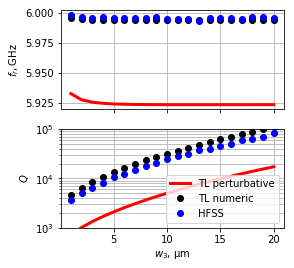

In [158]:
figs, axes = plt.subplots(2, sharex=True, figsize=(4,4))
left = axes[0]
right = axes[1]
left.plot(sim_compare.index, sim_compare['f_r analytic']/1e9, color='red', label='TL formula', linewidth=3)
left.plot(sim_compare.index, sim_compare['f_r numeric']/1e9, marker='o', color='black', linestyle='None', label='TL numeric')
left.plot(sim_compare.index, sim_compare['fr']/1e9, marker='o', color='blue', linestyle='None', label='HFSS')
#left.xlabel('$w_3$, $\mathrm{\mu m}$')
left.grid()

left.set_ylabel('$f_r, \mathrm{GHz}$')
right.semilogy(sim_compare.index, sim_compare['Q analytic'], color='red', label='TL perturbative', linewidth=3)
right.semilogy(sim_compare.index, sim_compare['Q numeric'], marker='o', color='black', linestyle='None', label='TL numeric')
right.semilogy(sim_compare.index, sim_compare['Qc_dia_corr'], marker='o', color='blue', linestyle='None', label='HFSS')
right.set_xlabel('$w_3$, $\mathrm{\mu m}$')
right.set_ylabel('$Q$')
right.set_ylim([1e3, 1e5])
right.grid()
right.grid(which='minor')
right.legend(fontsize=10, numpoints=1, loc='lower right')

# Optimizing coupler and short length

In [21]:
#sympy.solve(sympy.Matrix(M).det(), sympy.Symbol('\\omega'))

target_frequency = 5e9
target_Q = 30000

target_frequency_complex = 2*np.pi*target_frequency - 1j*target_frequency/target_Q*np.pi
#target_frequency_complex = sympy.Symbol('\\omega_r')
#target_frequency_complex = 6e9*2*np.pi-1j*2*np.pi*0.1e6 

Z_feedline = source.Z0

substitutions = {c_l: scipy.constants.c/np.sqrt(6.225), \
                 Zr: 50, \
                 Zo: 50, \
                 Zi: 50, \
                 Zf: 50, \
                 C_c: 6e-15, \
                 R: 0, \
                 l_o: 1e-6, \
                 l_f: 0, \
                 Z1: 50, \
                 Z2: 50, \
                 sympy.Symbol('\\omega'):target_frequency_complex, \
                 l_c: 400e-6}

M_numerical = sympy.Matrix(boundary_problem)
for i in range(boundary_problem.shape[0]):
    for j in range(boundary_problem.shape[1]):
        M_numerical[i,j] = M_numerical[i,j].subs(substitutions)
        
def equation(M_val, l_s_val):
    M_numpy = np.zeros(M_numerical.shape, dtype=np.complex)
    for i in range(boundary_problem.shape[0]):
        for j in range(boundary_problem.shape[1]):
            M_numpy[i,j] = M_numerical[i,j].subs({kappa:M_val, l_s:l_s_val})
           
    determinant = np.linalg.det(M_numpy)
    return (determinant.real, determinant.imag)

l_s_0 = (substitutions[c_l]/4.0/(substitutions[sympy.Symbol('\\omega')]/(2*np.pi))).real - substitutions[l_o]  - substitutions[l_c]
M_0 = 0.1

#print (l_s_0)
scale = np.asarray((M_0, l_s_0))
solution = scipy.optimize.fsolve(lambda x: equation(*(x*scale)), (1,1))*scale
M_optimized = np.abs(solution[0])
l_s_optimized = solution[1]

print('coupling kappa: ', np.abs(solution[0]), ', CPW short end length: ', solution[1], 'm')
#print(equation(*(solution)))

coupling kappa:  0.0688308444541 , CPW short end length:  0.00556799651826 m


# Getting cross-section geometry from coupling coefficient 

In [ ]:
from scipy.optimize import minimize_scalar
cpw_c = coplanar_coupler()
cpw_c.w1 = 30
cpw_c.w2 = 15
cpw_c.w3 = 48
cpw_c.s1 = 16
cpw_c.s2 = 8.5
cpw_c.epsilon_eff = 6.225

print(cpw_c.coupling_matrices())
target_coupling_matrix = np.asarray([[Z1_subs.evalf(subs={Z0:substitutions[Z0], M:M_optimized}), M_optimized], \
                                     [M_optimized, Z2_subs.evalf(subs={Zr:substitutions[Zr], M:M_optimized})]])
print (target_coupling_matrix)
def Zl_error(w3):
    if w3 < np.min([cpw_c.w1, cpw_c.w2, cpw_c.s1, cpw_c.s2])*0.01:
        w3 = np.min([cpw_c.w1, cpw_c.w2, cpw_c.s1, cpw_c.s2])*0.01
    cpw_c.w3 = w3
    Ll, Cl, Zl = cpw_c.coupling_matrices()
    coupling_matrix_error_metric = np.sum((Zl-target_coupling_matrix)**2)/np.sum((target_coupling_matrix)**2)
    print (w3, Zl, coupling_matrix_error_metric)
    return coupling_matrix_error_metric

minimize_scalar(Zl_error)